# Modelo C

Autor: Andres Cordero

# Setup del cuaderno

In [152]:
import pandas as pd
from ydata_profiling import ProfileReport

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
from num2words import num2words
import matplotlib.pyplot as plt
import re, string, unicodedata
import matplotlib
matplotlib.use('Qt5Agg')
%matplotlib inline
import numpy as np
import inflect
import joblib
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\arisc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arisc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arisc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Entendimiento de los datos

In [77]:
df_original = pd.read_csv(r'C:\Users\arisc\Trabajos\Universidad\10 Semestre\BI\BI_PROY1_2402\Proyecto 1\Etapa 1\Datasets\ODScat_345.csv', encoding='utf-8')
df_test_original = pd.read_excel(r'C:\Users\arisc\Trabajos\Universidad\10 Semestre\BI\BI_PROY1_2402\Proyecto 1\Etapa 1\Datasets\TestODScat_345.xlsx')
df_original.head()

,Textos_espanol,sdg
0,"Por ejemplo, el nÃºmero de consultas externas ...",3
1,"En 2007, el gobierno central financió directam...",3
2,"Claramente, hay muchos otros factores en juego...",3
3,"Por ejemplo, el estado australiano de Victoria...",3
4,"El consumo anual de alcohol se estima en 15,7 ...",3


In [78]:
train = df_original.copy()
train.head()

,Textos_espanol,sdg
0,"Por ejemplo, el nÃºmero de consultas externas ...",3
1,"En 2007, el gobierno central financió directam...",3
2,"Claramente, hay muchos otros factores en juego...",3
3,"Por ejemplo, el estado australiano de Victoria...",3
4,"El consumo anual de alcohol se estima en 15,7 ...",3


## Calidad de los datos

Dimensiones de calidad de los datos:
+ Consistencia
+ Validez
+ Completitud
+ Unicidad

### Completitud

Bajo una inspección sencilla, parece no haber problemas de completitud en los datos

In [79]:
train['sdg'].value_counts()

sdg
5    1451
4    1354
3    1244
Name: count, dtype: int64

In [80]:
# strip all values in the column
train['Textos_espanol'] = train['Textos_espanol'].str.strip()

# count all values in the column where the value is an empty string
train['Textos_espanol'].isnull().sum()

0

### Validez

Se identifican los siguietnes problemas de validez:
+ Hay un problema de codificación de los textos en el dataset, pues muchos caracteres que corresponden a vocales con tilde han sido reemplazados por caracteres no válidos.

In [81]:
def fix_encoding(text):
    replacements = {
        'Ã¡': 'á',
        'Ã©': 'é',
        'Ã­': 'í',
        'Ã³': 'ó',
        'Ãº': 'ú',
        'Ã±': 'ñ'
    }
    
    for wrong, correct in replacements.items():
        text = text.replace(wrong, correct)
    
    return text

train['Textos_espanol'] = train['Textos_espanol'].apply(fix_encoding)

In [82]:
train.head(5)

,Textos_espanol,sdg
0,"Por ejemplo, el número de consultas externas d...",3
1,"En 2007, el gobierno central financió directam...",3
2,"Claramente, hay muchos otros factores en juego...",3
3,"Por ejemplo, el estado australiano de Victoria...",3
4,"El consumo anual de alcohol se estima en 15,7 ...",3


### Consistencia

Algunas de las entradas de texto del dataset están rodeadas por comillas dobles, aunque no todas. Es posible que esto no introduzca problemas en el dataset. 

### Unicidad

En primera instancia, el dataset no tiene columnas que deban ser únicas siguiento algúna restricción de negocio. Bajo una inspección sencilla, parece no haber filas totalmente duplicadas.

In [83]:
train.duplicated().sum()

0

## Perfilamiento de los datos

Se aprovecha el paquete ydata-profiling para hacer un perfilamiento detallado del dataset. A partir de este reporte se destacan las siguientes conclusiones:
+ Variables: 2
+ Observaciones: 4049

|Variable|Tipo|
|--|--|
|Textos_espanol|Text|
|sdg|Categórica|

+ Se observa con ayuda del wordcloud que las palabras mas frecuentes en el dataset son stopwords que podrían ser eliminadas en el paso de procesamiento de datos. 


In [84]:
profile = ProfileReport(train, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [85]:
def mostrar_grafico1(palabras,stopwords=[]):
    comment_words = ''
    
    # iterate through the csv file
    for val in palabras:
        
        # typecaste each val to string
        val = str(val)
    
        # split the value
        tokens = val.split()
        
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        
        comment_words += " ".join(tokens)+" "
    
    
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)
    
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0)
    
    plt.show()

Acontinuación se va a ilustrar que palabras suelen repetirse y encontrarse en las clasificaciones 3, 4 y 5

---------- Words for class: 3 ----------


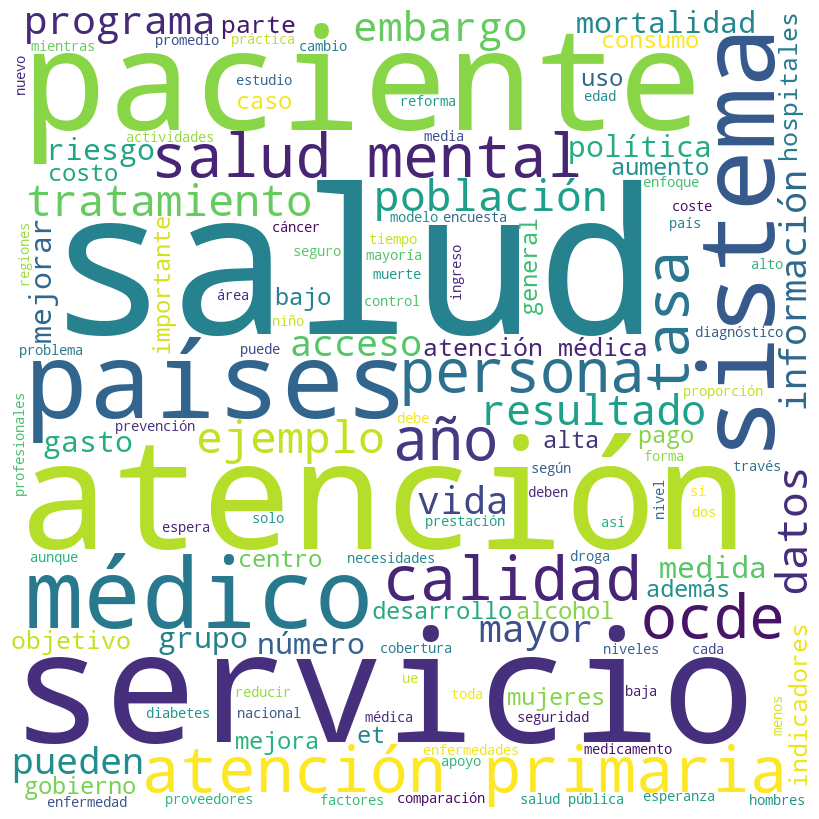

---------- Words for class: 4 ----------


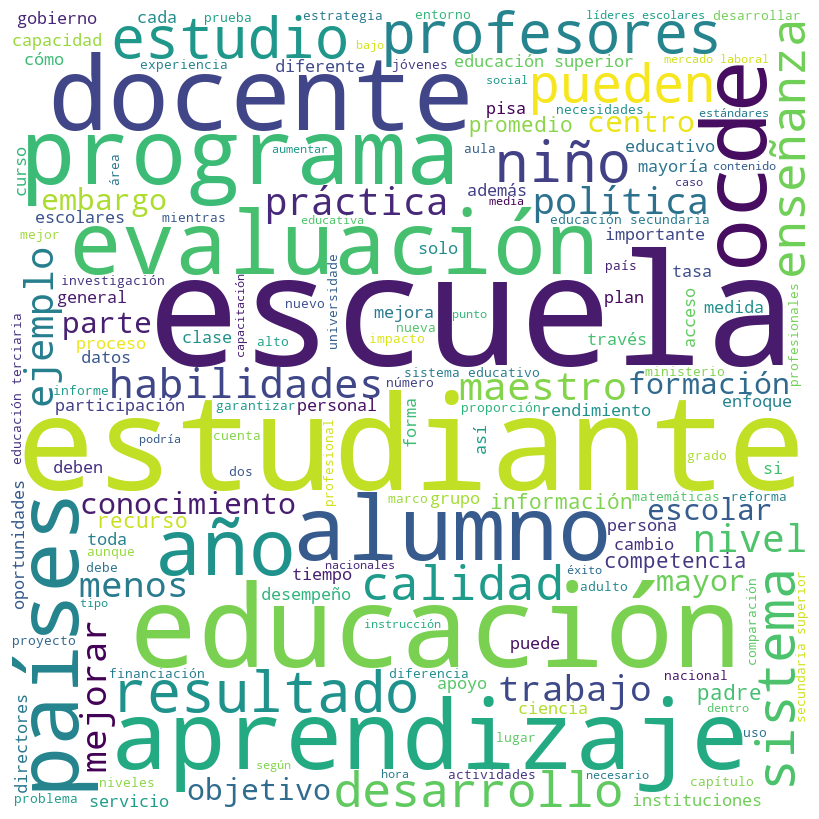

---------- Words for class: 5 ----------


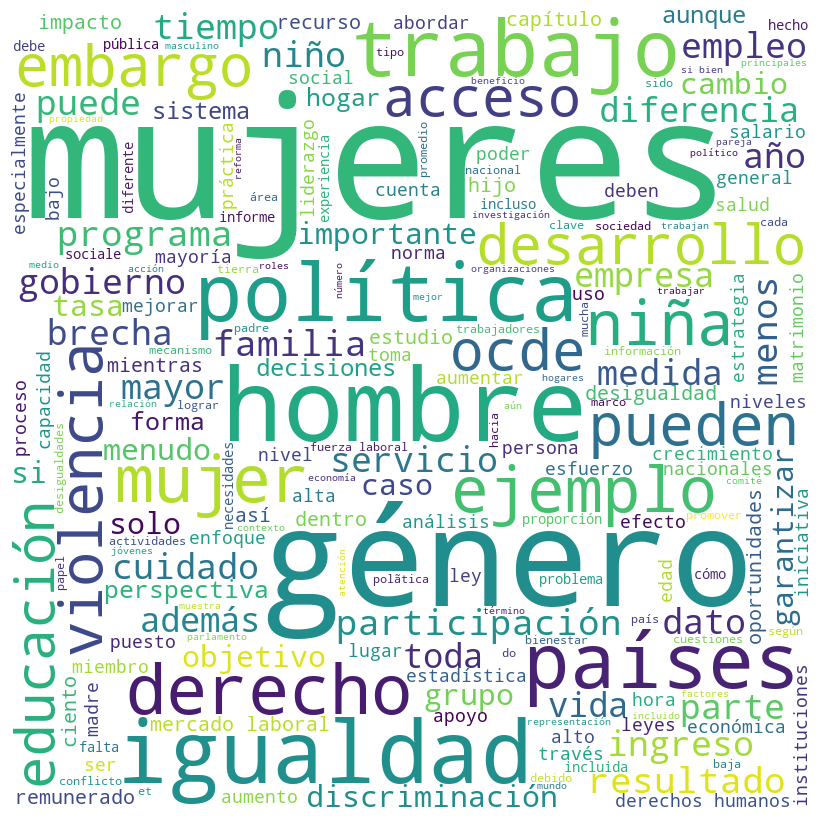

In [86]:
stop_words = set(nltk.corpus.stopwords.words('spanish'))

for i in train['sdg'].unique():
    print(f'---------- Words for class: {i} ----------')
    mostrar_grafico1(train.loc[train['sdg']==i,'Textos_espanol'], stopwords=stop_words)

In [87]:
train

,Textos_espanol,sdg
0,"Por ejemplo, el número de consultas externas d...",3
1,"En 2007, el gobierno central financió directam...",3
2,"Claramente, hay muchos otros factores en juego...",3
3,"Por ejemplo, el estado australiano de Victoria...",3
4,"El consumo anual de alcohol se estima en 15,7 ...",3
...,...,...
4044,"Para ello, identificará las cuestiones de géne...",5
4045,La participación de las mujeres en roles de li...,5
4046,"Según el WEF, según las tendencias de 2016, po...",5
4047,"Sirve como recurso y foro para las agencias, c...",5


# Preparación de los datos

In [88]:
X_train, y_train = train['Textos_espanol'], train['sdg'] 
display(X_train)
y_train

0       Por ejemplo, el número de consultas externas d...
1       En 2007, el gobierno central financió directam...
2       Claramente, hay muchos otros factores en juego...
3       Por ejemplo, el estado australiano de Victoria...
4       El consumo anual de alcohol se estima en 15,7 ...
                              ...                        
4044    Para ello, identificará las cuestiones de géne...
4045    La participación de las mujeres en roles de li...
4046    Según el WEF, según las tendencias de 2016, po...
4047    Sirve como recurso y foro para las agencias, c...
4048    Las áreas útiles para un mayor estudio y acció...
Name: Textos_espanol, Length: 4049, dtype: object

0       3
1       3
2       3
3       3
4       3
       ..
4044    5
4045    5
4046    5
4047    5
4048    5
Name: sdg, Length: 4049, dtype: int64

#### **3.1 Eliminación del ruido**

Este proceso se realiza para dejar el archivo en texto plano. Para ello se pasan todos los caracteres a minuscula, se eliminan los textos de puntuación y asi mismo las stop words (que suelen ser palabras como articulos y conectores) y para este caso decidimos eliminar los números. Puesto que no dan mayor significancia y se repetian bastante en los textos.

In [89]:
def to_lower(words: list[str]):
    return [word.lower() for word in words]

def remove_punctuation(words: list[str]):
    return [word for word in words if word.isalnum()]

def remove_stopwords(words: list[str]):
    stopwords = set(nltk.corpus.stopwords.words('spanish'))
    return [word for word in words if word not in stopwords]

def remove_numbers(words):
    new_words = []
    for word in words:
        if not word.isdigit(): 
            new_words.append(word)  
    return new_words

def preprocessing(words):
    words = to_lower(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = remove_numbers(words)
    return words

#### **3.2 Tokenización**
A continuación se tokeniza, con el fin de desglozar las palabras correctamente para el posterior análisis.

In [90]:
new_X_train = X_train.apply(word_tokenize)
new_X_train = new_X_train.apply(preprocessing) 
new_X_train.head()

0    [ejemplo, número, consultas, externas, especia...
1    [gobierno, central, financió, directamente, so...
2    [claramente, factores, juego, particular, vari...
3    [ejemplo, australiano, victoria, creó, agencia...
4    [consumo, anual, alcohol, estima, litros, año,...
Name: Textos_espanol, dtype: object

#### **3.3 Normalización**
Para la normalización de los datos se realiza unicamente una  lemmatización de los verbos. Puesto que se probo realizar de misma forma la estematización (eliminación de prefijos y sufijos) junto con la lemmatización y solo la estematización.

El mejor resultado de normalización lo obtuvo solo realizar la lemmatización.

In [91]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = SnowballStemmer('spanish')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    #words = stem_words(words)
    words = lemmatize_verbs(words)
    return words

new_X_train = new_X_train.apply(stem_and_lemmatize) 
new_X_train.head()

0    [ejemplo, número, consultas, externas, especia...
1    [gobierno, central, financió, directamente, so...
2    [claramente, factor, juego, particular, varied...
3    [ejemplo, australiano, victoria, creó, agencia...
4    [consumo, anual, alcohol, estima, litros, año,...
Name: Textos_espanol, dtype: object

Antes de realizar la vectorización del preprocesamiento es necesario unir las palabras tokenizadas en una sola cadena de string.

In [92]:
def concatenar (words):
    return ' '.join(words)

new_X_train = new_X_train.apply(concatenar)
new_X_train.head()

0    ejemplo número consultas externas especialista...
1    gobierno central financió directamente solo ga...
2    claramente factor juego particular variedad ba...
3    ejemplo australiano victoria creó agencia prom...
4    consumo anual alcohol estima litros año hombre...
Name: Textos_espanol, dtype: object

Por últmo se va a vectorizar las palabras para pasarle esta información al modelo.

Se decidio hacer una vectorización Tfidf de los datos puesto que esta vectorización funciona mejor en tareas de clasificación de textos, ya que destaca mejor las palabras importantes en el contexto de clasificación.

Además también se hicieron pruebas con otras vectorizaciones y esta dio el mejor resultado.

In [93]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(new_X_train)

print(X_tfidf.shape)
X_tfidf

(4049, 18782)


<4049x18782 sparse matrix of type '<class 'numpy.float64'>'
	with 191653 stored elements in Compressed Sparse Row format>

# Entrenar un modelo KNN

In [94]:
X = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
X.head()
X_train = X
X_train

,04s,10º,12m,12º,14ª,15ª,17ccem,17ª,1991b,1992a,...,últimos,única,únicamente,únicas,único,únicos,úsalo,útero,útil,útiles
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [95]:
X_train.isnull().sum()

04s       0
10º       0
12m       0
12º       0
14ª       0
         ..
únicos    0
úsalo     0
útero     0
útil      0
útiles    0
Length: 18782, dtype: int64

In [96]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

best_n = 1
best_accuracy = 0
act_accuracy = 0
resultados = []

for i in range(1, 100):
    if i % 10 == 0:
        print(f"Actualmente probando con {i} neighbors")
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train2, y_train2)
    y_pred = knn.predict(X_test2)
    act_accuracy = accuracy_score(y_test2, y_pred)
    resultados.append((i,act_accuracy))
    if act_accuracy > best_accuracy:
        best_accuracy = act_accuracy
        best_n = i

print(f'Best accuracy: {best_accuracy} with n_neighbors: {best_n}')

Actualmente probando con 10 neighbors
Actualmente probando con 20 neighbors
Actualmente probando con 30 neighbors
Actualmente probando con 40 neighbors
Actualmente probando con 50 neighbors
Actualmente probando con 60 neighbors
Actualmente probando con 70 neighbors
Actualmente probando con 80 neighbors
Actualmente probando con 90 neighbors
Best accuracy: 0.9765432098765432 with n_neighbors: 32


In [106]:
# Ordenar los resultados por precisión de mayor a menor
resultados.sort(key=lambda x: x[1], reverse=True)

# Obtener los 5 mejores valores de n_neighbors y sus precisiones
top_5 = resultados[:5]

# Imprimir los 5 mejores resultados
for n, accuracy in top_5:
    print(f"n_neighbors: {n}, accuracy: {accuracy:.4f}")

n_neighbors: 32, accuracy: 0.9765
n_neighbors: 46, accuracy: 0.9765
n_neighbors: 24, accuracy: 0.9753
n_neighbors: 33, accuracy: 0.9753
n_neighbors: 34, accuracy: 0.9753


In [98]:
knn = KNeighborsClassifier(n_neighbors=best_n)
knn.fit(X_train2, y_train2)
y_pred = knn.predict(X_test2)

In [99]:
# Calculate the accuracy
print(accuracy_score(y_test2, y_pred))

print(classification_report(y_test2, y_pred))

0.9765432098765432
              precision    recall  f1-score   support

           3       0.98      0.96      0.97       250
           4       0.97      0.99      0.98       268
           5       0.97      0.98      0.98       292

    accuracy                           0.98       810
   macro avg       0.98      0.98      0.98       810
weighted avg       0.98      0.98      0.98       810



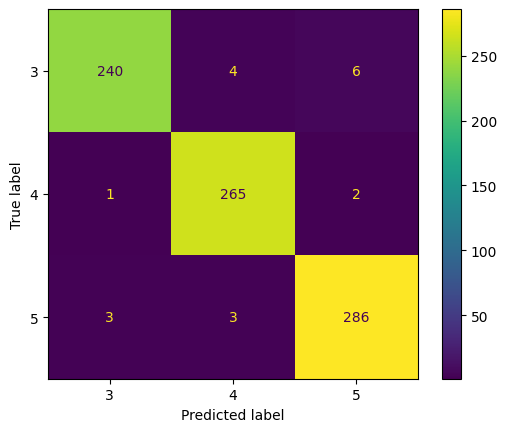

In [100]:
cm = confusion_matrix(y_test2, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()

# Realización del Pipeline

In [122]:
# 1. Strip
def strip_text(X):
    return X.str.strip()

# 2. Fix encoding
def replace(text):
    replacements = {
        'Ã¡': 'á',
        'Ã©': 'é',
        'Ã­': 'í',
        'Ã³': 'ó',
        'Ãº': 'ú',
        'Ã±': 'ñ'
    }
    for wrong, correct in replacements.items():
        text = text.replace(wrong, correct)
    return text

def fix_encoding_array(X):
    return X.apply(replace)

# 3. Preprocessing
def to_lower(words: list[str]):
    return [word.lower() for word in words]

def remove_punctuation(words: list[str]):
    return [word for word in words if word.isalpha()]

def remove_stopwords(words: list[str]):
    stopwords = set(nltk.corpus.stopwords.words('spanish'))
    return [word for word in words if word not in stopwords]

def remove_numbers(words: list[str]):
    return [word for word in words if not word.isdigit()]

def preprocessing(words: list[str]):
    words = to_lower(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = remove_numbers(words)
    return words

def preprocessing_array(X):
    return X.apply(preprocessing)

# 4. Tokenize
def word_tokenize_spanish(text):
    return word_tokenize(text, language='spanish')

def word_tokenize_spanish_array(X):
    X = X.apply(word_tokenize_spanish)
    return X

# 5. Lemmatize
def lemmatize(words):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def lemmatize_array(X):
    X = X.apply(lemmatize)
    return X

# 6. Concatenate words
def concat_words(words):
    return ' '.join(map(str, words))

def concat_words_array(X):
    return X.apply(concat_words)


preprocessing_pipeline = Pipeline([
    ('strip', FunctionTransformer(strip_text)),
    ('fix_encoding', FunctionTransformer(fix_encoding_array)),
    ('tokenize', FunctionTransformer(word_tokenize_spanish_array)),
    ('preprocessing', FunctionTransformer(preprocessing_array)),
    ('lemmatize', FunctionTransformer(lemmatize_array)),
    ('concat', FunctionTransformer(concat_words_array))
])

vectorization_clf_pipeline = Pipeline([
    ('b_o_w', TfidfVectorizer()),
    ('clf', KNeighborsClassifier())
])

pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('vectorization_clf', vectorization_clf_pipeline)
])

# Prueba de pipeline

### Validación cruzada

In [127]:
df_original = pd.read_excel('../Datasets/ODScat_345.xlsx')

In [128]:
X_train, X_test, y_train, y_test = train_test_split(
    df_original["Textos_espanol"], df_original["sdg"], test_size=0.2, random_state=42
)
y_pred_test = pipeline.fit(X_train, y_train).predict(X_test)
print(accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

0.9432098765432099
              precision    recall  f1-score   support

           3       0.95      0.93      0.94       250
           4       0.93      0.97      0.95       268
           5       0.95      0.93      0.94       292

    accuracy                           0.94       810
   macro avg       0.94      0.94      0.94       810
weighted avg       0.94      0.94      0.94       810



### Búsqueda de un hiperparámetros con Grid Search

In [131]:
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

X = df_original["Textos_espanol"]
X = preprocessing_pipeline.transform(X)
y = df_original["sdg"]
scores = cross_val_score(vectorization_clf_pipeline, X, y, cv=kfold)

print(scores)
print(f"Scores mean: {scores.mean()}")

[0.93333333 0.94567901 0.95061728 0.95061728 0.95555556 0.92839506
 0.93333333 0.95555556 0.94074074 0.94306931]
Scores mean: 0.9436896467424521


In [134]:
param_grid = {
    'clf__n_neighbors': [24, 32, 33, 34, 46],
    'clf__p': [1, 2], #Función de distancia 1: manhattan, 2: euclidean
    'clf__weights': ['uniform', 'distance'],
    'b_o_w__min_df': [0.0, 0.1, 0.2],
    'b_o_w__max_df': [1.0, 0.9, 0.8]
}
X = df_original["Textos_espanol"]
y = df_original["sdg"]

X = preprocessing_pipeline.transform(X)

grid_search = GridSearchCV(vectorization_clf_pipeline, param_grid, cv=kfold, n_jobs=-1, verbose=2)
grid_search.fit(X, y)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('b_o_w', TfidfVectorizer()),
                                       ('clf', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'b_o_w__max_df': [1.0, 0.9, 0.8],
                         'b_o_w__min_df': [0.0, 0.1, 0.2],
                         'clf__n_neighbors': [24, 32, 33, 34, 46],
                         'clf__p': [1, 2],
                         'clf__weights': ['uniform', 'distance']},
             verbose=2)

In [136]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Best parameters: {'b_o_w__max_df': 1.0, 'b_o_w__min_df': 0.0, 'clf__n_neighbors': 46, 'clf__p': 2, 'clf__weights': 'distance'}
Best cross-validation score: 0.9686


### Correción del Pipeline con los hiperparámetros

In [137]:
vectorization_clf_pipeline_hiperparametros = Pipeline([
    ('b_o_w', TfidfVectorizer(min_df=0.0, max_df=1.0)),
    ('clf', KNeighborsClassifier(n_neighbors=46, p=2, weights='distance'))
])

pipeline_final = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('vectorization_clf', vectorization_clf_pipeline_hiperparametros)
])

In [141]:
X_train, X_test, y_train, y_test = train_test_split(df_original["Textos_espanol"], df_original["sdg"], test_size=0.2, random_state=42)
y_pred_test = pipeline_final.fit(X_train, y_train).predict(X_test)

0.9765432098765432
              precision    recall  f1-score   support

           3       0.98      0.96      0.97       250
           4       0.97      0.99      0.98       268
           5       0.97      0.98      0.98       292

    accuracy                           0.98       810
   macro avg       0.98      0.98      0.98       810
weighted avg       0.98      0.98      0.98       810



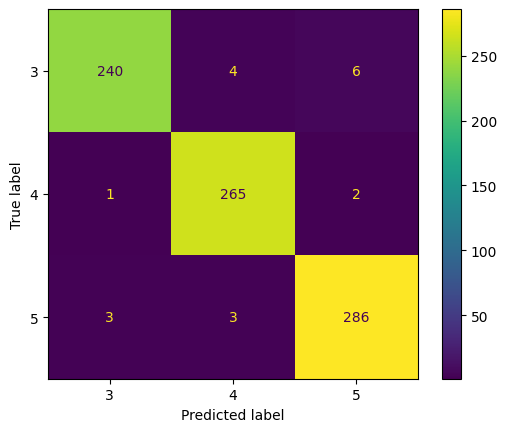

In [142]:
# Calculate the accuracy
print(accuracy_score(y_test2, y_pred))

print(classification_report(y_test2, y_pred))
cm = confusion_matrix(y_test2, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()

# Prueba de pipeline con dataset de prueba final

In [139]:
df_original = pd.read_excel('../Datasets/ODScat_345.xlsx')
X_data = df_original['Textos_espanol']
y_data = df_original['sdg']

X_data = df_original['Textos_espanol']
y_full = df_original['sdg']
y_pred_full = pipeline_final.fit(X_data, y_full).predict(X_data)

In [140]:
print(accuracy_score(y_full, y_pred_full))
print(classification_report(y_full, y_pred_full))

1.0
              precision    recall  f1-score   support

           3       1.00      1.00      1.00      1244
           4       1.00      1.00      1.00      1354
           5       1.00      1.00      1.00      1451

    accuracy                           1.00      4049
   macro avg       1.00      1.00      1.00      4049
weighted avg       1.00      1.00      1.00      4049



In [143]:
df_test_original = pd.read_excel('../Datasets/TestODScat_345.xlsx')

In [144]:
X_test = df_test_original['Textos_espanol']
y_pred_test = pipeline.predict(X_test)
df_test_original['sdg'] = y_pred_test
df_test_original.to_excel('./output.xlsx', index=False)
df_test_original.to_csv('./output.csv', index=False)

# Serializar modelo

In [156]:
# Serialize model
joblib.dump(pipeline_final, 'pipeline_modelo_knn.joblib')

['pipeline_modelo_knn.joblib']